In [69]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pathlib import Path
import sklearn
import numpy as np
import torch
import torchvision
from torch import nn, optim
from torchvision import transforms, datasets
import matplotlib.colors as colors
import pandas as pd
import openpyxl

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import shapely
from shapely.geometry import Point, Polygon

from matplotlib.patches import Rectangle

xr.__version__

'0.17.0'

In [2]:
file = Path('../../Data/VagelisDATA','OWT_MasterSheet_corrected.xlsx')
transect = pd.read_excel(file, sheet_name='transect')
stations = pd.read_excel(file, sheet_name='stations')


tempsal1 = pd.read_excel('../../Data/VagelisDATA/PROFAN_termosalinografo.xlsx', sheet_name='Primera_segunda_parte')
tempsal2 = pd.read_excel('../../Data/VagelisDATA/PROFAN_termosalinografo.xlsx', sheet_name='Tercera_parte')
frames = [tempsal1,tempsal2]
TempSal = pd.concat(frames) #combining the in-situ data


## Opeing file as worksheet
#file = Path('../../Data/VagelisDATA','OWT_MasterSheet_corrected.xlsx')
#workbook = openpyxl.load_workbook(file)
#stations = workbook['stations']
#transect = workbook['transect']

In [3]:
TempSal#['DateTime'].values.min()

,Cruise,Station,Type,yyyy-mm-ddThh:mm:ss.sss,Longitude [degrees East],Latitude [degrees North],Bot. Depth [m],Depth [m],Temperature [°C],Salinity [psu],Unnamed: 10
0,PROFAN_termo_1,1,C,2019-11-15T01:54:05,-72.86764,-41.69316,0,3,16.1879,28.4474,NaN
1,PROFAN_termo_1,2,C,2019-11-15T01:54:15,-72.86756,-41.69370,0,3,16.1907,28.4578,NaN
2,PROFAN_termo_1,3,C,2019-11-15T01:54:25,-72.86746,-41.69424,0,3,16.1843,28.4819,NaN
3,PROFAN_termo_1,4,C,2019-11-15T01:54:35,-72.86738,-41.69476,0,3,16.1702,28.5214,NaN
4,PROFAN_termo_1,5,C,2019-11-15T01:54:45,-72.86728,-41.69530,0,3,16.1531,28.5727,NaN
...,...,...,...,...,...,...,...,...,...,...,...
43340,PROFAN_termo_3,92369,C,2019-11-25T14:06:27,-72.86662,-41.68264,0,3,14.3053,29.5724,NaN
43341,PROFAN_termo_3,92370,C,2019-11-25T14:06:37,-72.86662,-41.68214,0,3,14.3374,29.5228,NaN
43342,PROFAN_termo_3,92371,C,2019-11-25T14:06:47,-72.86664,-41.68164,0,3,14.3717,29.4735,NaN
43343,PROFAN_termo_3,92372,C,2019-11-25T14:06:57,-72.86664,-41.68114,0,3,14.4015,29.4285,NaN


# Combined Cartopy

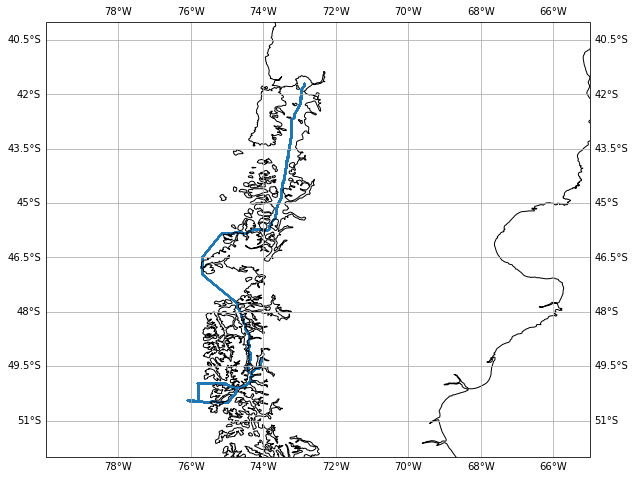

In [3]:
fig = plt.figure(figsize=(15, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-80, -65, -40, -52], crs=ccrs.PlateCarree());
#ax.set_global()


lontemp = TempSal['Longitude [degrees East]']
lattemp = TempSal['Latitude [degrees North]']


ax.scatter(lontemp, lattemp, s=0.1, transform = ccrs.PlateCarree())

## Seaborn

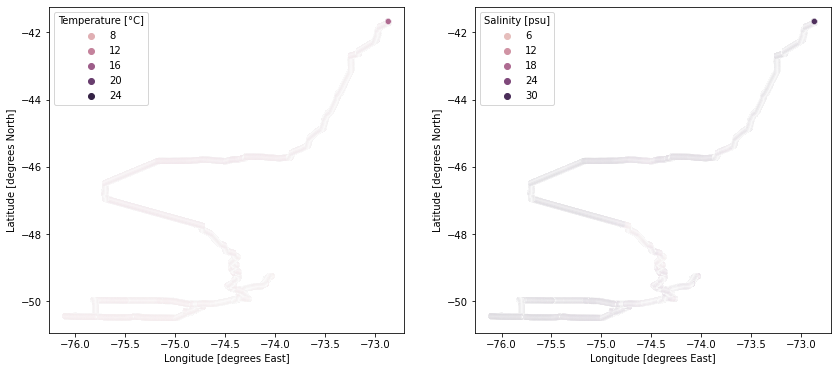

In [4]:
fig, axs = plt.subplots(ncols=2,figsize=(14,6))

sns.color_palette("viridis", as_cmap=True)


sns.scatterplot(x='Longitude [degrees East]', y='Latitude [degrees North]', data=TempSal, hue='Temperature [°C]'
                ,ax=axs[0])
sns.scatterplot(x='Longitude [degrees East]', y='Latitude [degrees North]', data=TempSal, hue='Salinity [psu]'
                ,ax=axs[1])


# Plotting with Cartopy and Colour bar


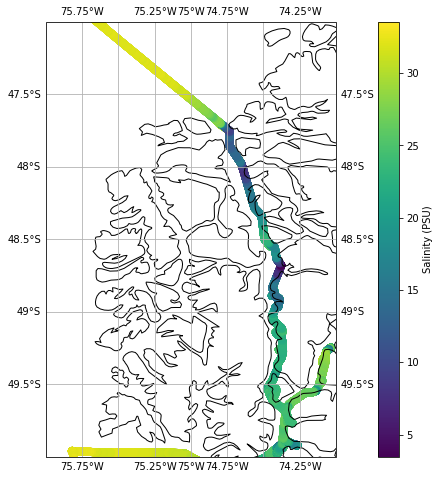

In [55]:
lon = TempSal['Longitude [degrees East]']
lat = TempSal['Latitude [degrees North]']
temp = TempSal['Temperature [°C]']
sal = TempSal['Salinity [psu]']


plt.figure(figsize=(15,8))
s=20
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-76, -74, -47, -50], crs=ccrs.PlateCarree());
#ax.set_extent([-80, -65, -40, -52], crs=ccrs.PlateCarree());
ax.gridlines(draw_labels=True) #linewidth=2, color='gray', alpha=0.5, linestyle='--')
# Colour bar
#cbar_norm = mpl.colors.Normalize(vmin=0.0, vmax=30.0)
#tempmap = ax.pcolormesh(lon, lat, temp, norm=cbar_norm)


label = 'Salinity (PSU)'  #
max_color_by = max(sal)
min_color_by = min(sal)
cmap = plt.cm.viridis
s = ax.scatter(lon, lat,c=sal,s=50,marker='o',
               cmap = plt.cm.viridis,       # Color pallete
               vmin = min_color_by,          # Min value
               vmax = max_color_by)          # Max value
cbar = plt.colorbar(mappable = s, ax = ax)   # Mappable 'maps' the values of s to an array of RGB colors defined by a color palette
cbar.set_label(label)


In [30]:
sal.max()

33.5263

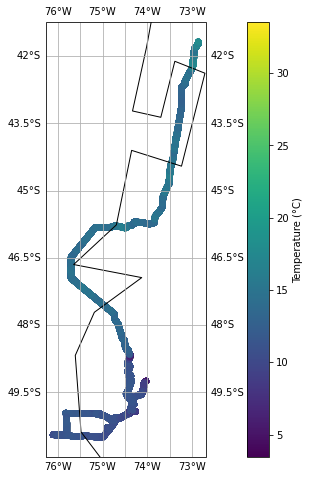

In [72]:
lon = TempSal['Longitude [degrees East]']
lat = TempSal['Latitude [degrees North]']
temp = TempSal['Temperature [°C]']
#temp = np.clip(temp, 4,25)

sal = TempSal['Salinity [psu]']


plt.figure(figsize=(15,8))
#s= 20
ax1 = plt.axes(projection=ccrs.PlateCarree())
ax1.coastlines()
#ax1.set_extent([-76, -74, -47, -50], crs=ccrs.PlateCarree());
ax1.gridlines(draw_labels=True) #linewidth=2, color='gray', alpha=0.5, linestyle='--')
# Colour bar
#cbar_norm = mpl.colors.Normalize(vmin=0.0, vmax=30.0)
#tempmap = ax.pcolormesh(lon, lat, temp, norm=cbar_norm)


label = 'Temperature (°C)'  #
max_color_by = max(temp)
min_color_by = min(temp)
cmap = plt.cm.viridis
ax1.scatter(lon, lat,c=temp,s=30,marker='o',
               cmap = plt.cm.viridis,      # Color pallete
               vmin = min_color_by,          # Min value
               vmax = max_color_by)          # Max value


ax1.add_patch( Rectangle((-47, -74),
                         -50, -76,
                        fc='none',
                        color ='yellow',
                        linewidth = 5,
                        ) )

cbar = plt.colorbar(mappable = s, ax = ax1)## Mappable 'maps' the values of s to an array of RGB colors defined by a color palette
cbar.set_label(label)


In [59]:
max_color_by

24.5716

In [7]:
ops = len(TempSal)*(len(stations)+len(transect))
ops*0.001/ 3600



21.605018333333334

In [6]:
temp

0        16.1879
1        16.1907
2        16.1843
3        16.1702
4        16.1531
          ...   
43340    14.3053
43341    14.3374
43342    14.3717
43343    14.4015
43344    14.4307
Name: Temperature [°C], Length: 92373, dtype: float64